# <b> MNIST Object Detection CNNs


## **Context**

The MNIST handwritten digit classification problem is a standard and widely used dataset in computer vision and deep learning.
Although the dataset is effectively solved, it can be used as the basis for learning and practicing how to develop, evaluate, and use convolutional deep learning neural networks for image classification and object detection from scratch. This includes developing a robust test harness for estimating model performance and exploring improvements to the model.

The MNIST dataset is essentially a dataset of 10,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.  <br><br>
<b>MNIST Object Detection Data: Overview </b>
- This dataset is provided in a zipped format. 
- This zip consists of two folders - train and test. Both these folders consist of two more sub-folders, images and labels. 
- The images subfolder in the train folder consists of images starting from **0.png** to **9000.png** whereas the labels folder consists of text files starting from **0.txt** to **9000.txt**. Similarly, the test folder consists of images starting from **0.png** to **1000.png** whereas the labels folder consists of text files starting from **0.txt** to **1000.txt**. <br>

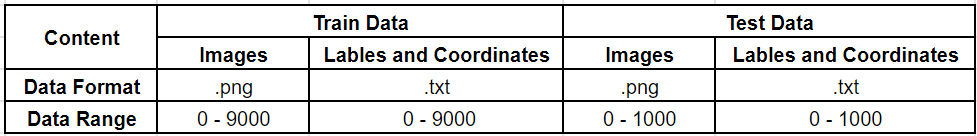
<br>
- Each image has its corresponding label and bounding box in the labels folder. 
- For example: **0.png** has its label and coordinates of the bounding box in the **0.txt** file.
- The shape of an image in the dataset is hence **(300,300,3)**.

## **Objective**

**Object Detection** is **a combination of classification and regression.** 

In [ ]:
# Mounting the drive to load the data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Unzipping the Data**

In [ ]:
# Unzipping the zip file which contains the data
!unzip -q "/content/drive/MyDrive/Advanced CNN Recordings/Datasets/MNIST_Object_Detection.zip"

## **Importing the Libraries**

In [ ]:
import os                                 # Importing os module to get the path
from os import listdir                    # Importing listdir module to get the list of directories or files
import numpy as np                        # Imporing numpy for numerical operations
import pandas as pd                       # importing pandas to read csv or txt files
import matplotlib.pyplot as plt           # Importing Matplolib for ploting graphs and visualizing images
import cv2                                # importing opencv to work on images
import seaborn as sns                     # importing seaborn for data visualization 
import tensorflow as tf                   # Importing tensorflow for tensor operations or model building
import keras                              # Importing keras for model building
from tensorflow.keras.models import Sequential, Model                 # sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten           # Importing different layers like dense and flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, Activation # importing CNN layers and activations
from tensorflow.keras import backend                                  # Importing backend module to clear backend 
from tensorflow.keras.utils import to_categorical                     # Importing to_categorical to perform one-hot encoding 
from tensorflow.keras.optimizers import RMSprop,Adam,SGD #Importing optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  # regularization method to prevent the overfitting
from tensorflow.keras import losses, optimizers       # importing losses and optimizers from keras
from google.colab.patches import cv2_imshow           # importing cv2_imshow to display images

from sklearn.metrics import mean_absolute_error,mean_squared_error     # importing the error metrics for regression
from sklearn.metrics import accuracy_score, confusion_matrix           # importing the error metrics for classification

# Importing the transfer learning model- VGG16
from tensorflow.keras.applications import VGG16

## **Function to store training data in a list**

In [ ]:
# Read the data 

def create_training_data():
  training_data = []                                                            # Creating a list to store the training data
  IMG_SIZE=300                                                                  # initializing image size to 300
  # get the path/directory
  folder_dir = "/content/mnist_detection/train/images"                          # path for training images directory
  dirpath = "/content/mnist_detection/train/labels"                             # path for training labels directory
  
  list_dir=[int(file.split(".")[0]) for file in os.listdir(folder_dir)]         # separating the image name from extension and storing it in a list like 0.png is stored as 0 and 99.png is stored as 99.
  list_dir.sort()                                                               # sorting the image names in ascending order starting from 0

  label_dir=[int(file.split(".")[0]) for file in os.listdir(dirpath)]           # separating the label name from extension and storing it in a list like 0.txt is stored as 0 and 99.txt is stored as 99.
  label_dir.sort()                                                              # sorting the label names in ascending order starting from 0

  for images,filename,i in zip(list_dir,label_dir,range(10000)): 
            data = pd.read_csv((os.path.join(dirpath+'/' + str(filename)+".txt")), sep=',',  header=0)      # Reading each txt file with header as 0th row and each value is separated by comma.
           
            # Storing the four bounding boxes
            xmin=data['xmin'].values[0]
            xmax=data['xmax'].values[0]
            ymin=data['ymin'].values[0]
            ymax=data['ymax'].values[0]

            img_array = cv2.imread(os.path.join(folder_dir+'/' + str(images)+".png"))                       # Reading the image
            # Resizing each image to image_size=300 as we require each image to be of the same size before training the model without missing any image of a different size
            new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))                                          
            training_data.append([new_array,data['label'].values[0],(xmin,ymin,xmax,ymax)])                 # Appending the image array, 
  return training_data

# calling the create_training_data function
training_data=create_training_data()            
 

## **Function to create testing data**

In [ ]:
# Creating test data similar to train data
def create_testing_data():
  testing_data = []   
  IMG_SIZE=300
  # get the path/directory
  folder_dir = "/content/mnist_detection/test/images"
  dirpath = "/content/mnist_detection/test/labels"

  list_dir=[int(file.split(".")[0]) for file in os.listdir(folder_dir)]
  list_dir.sort()


  label_dir=[int(file.split(".")[0]) for file in os.listdir(dirpath)]
  label_dir.sort()

  for images,filename,i in zip(list_dir,label_dir,range(10000)): 
            data = pd.read_csv((os.path.join(dirpath+'/' + str(filename)+".txt")), sep=',',  header=0)
          
            xmin=data['xmin'].values[0]
            xmax=data['xmax'].values[0]
            ymin=data['ymin'].values[0]
            ymax=data['ymax'].values[0]

            img_array = cv2.imread(os.path.join(folder_dir+'/' + str(images)+".png"))                    
            new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))                                         
            testing_data.append([new_array,data['label'].values[0],(xmin,ymin,xmax,ymax)])  
  return testing_data

testing_data=create_testing_data() 

## **Splitting the images, labels and bounding boxes**

In [ ]:
X_train = []                                                                   
y_train = []
X_test = []                                                                   
y_test = []
y_train_boxes=[]
y_test_boxes=[]

for features,labels,boxes in training_data:                                     # Iterating over the training data which is generated from the create_training_data() function 
    X_train.append(features)                                                    # Appending images into X_train
    y_train.append(labels)                                                      # Appending labels to y_train
    y_train_boxes.append(boxes)                                                 # Appending bounding boxes to y_train_boxes
   
for features,labels,boxes in testing_data:                                      # Iterating over the testing data which is generated from the create_testing_data() function 
    X_test.append(features)                                                     # Appending images into X_test
    y_test.append(labels)                                                       # Appending labels to y_test
    y_test_boxes.append(boxes)                                                  # Appending bounding boxes to y_test_boxes

In [ ]:
# Converting the lists to numpy arrays and reshaping them to (300,300,3)
X_train=np.array(X_train).reshape(np.array(X_train).shape[0],300,300,3)
X_test=np.array(X_test).reshape(np.array(X_test).shape[0],300,300,3)

In [ ]:
X_train.shape,X_test.shape

((10000, 300, 300, 3), (1000, 300, 300, 3))

## **Preprocessing the Data**

In [ ]:
# scaling bounding box relative to image size
y_train_boxes_scaled=[]    # list to stored the scaled bounding boxes
y_test_boxes_scaled=[]     # list to stored the scaled bounding boxes
IMG_SIZE=300

# Scaling the train_boxes
for boxes in y_train_boxes:
  value = tuple(i/IMG_SIZE for i in boxes)
  y_train_boxes_scaled.append(value)

# Scaling the test_boxes
for boxes in y_test_boxes:
  value = tuple(i/IMG_SIZE for i in boxes)
  y_test_boxes_scaled.append(value)

## <b> Visualizing the Images

<b> Plotting the images with their corresponding labels

Text(0.5, 1.0, 'Image corresponds to: 4')

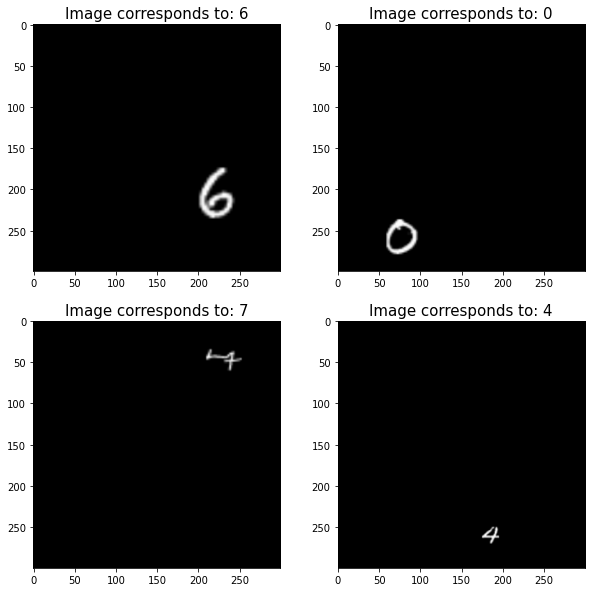

In [ ]:
# f = plt.figure(figsize=(100,100))
f, axarr = plt.subplots(2,2,figsize=(10,10))
axarr[0,0].imshow(X_train[100])
axarr[0,0].set_title("Image corresponds to: " + str(y_train[100]),{'fontsize':15})
axarr[0,1].imshow(X_train[200])
axarr[0,1].set_title("Image corresponds to: " + str(y_train[200]),{'fontsize':15})
axarr[1,0].imshow(X_train[300])
axarr[1,0].set_title("Image corresponds to: " + str(y_train[300]),{'fontsize':15})
axarr[1,1].imshow(X_train[400])
axarr[1,1].set_title("Image corresponds to: " + str(y_train[400]),{'fontsize':15})

### **Observations**
- We observe that each image consists of one number.
- The number may be present at different regions in the image, such as the bottom, top, left corner etc.
- We also observe the corresponding labels at the top of each image.

## <b> Visualizing the Bounding Boxes

In [ ]:
def plot_boxes(index):
  (startX, endX,startY, endY) = y_train_boxes_scaled[index]                     # Getting the coordinates of the boxes
  images = X_train[index]                                                       # Getting the image
  (h, w,_) = X_train[0].shape                                                   # Getting the height and width
 
  # Getting the coordinates to original height and width
  startX = int(startX*w)
  startY = int(startY*h)
  endX = int(endX*w)
  endY = int(endY*h)
 
  label = y_train[index]                                                        # Getting the label
  imgHeight, imgWidth, _ = images.shape                                         # Getting the height and width of the image
  thick = int((imgHeight + imgWidth) // 900)                                    # Giving a random thickness value for the rectangle
  color = (0,255,0)                                                             # Giving a color to the rectangle box
  
  # plotting the rectangle on the image with title
  cv2.rectangle(images,(startX, startY), (endX, endY), (0,255,0), thick)            # Plotting the rectangle box on the image
  cv2.putText(images, str(label), (startX, startY - 12), 0, 1* imgHeight, color)    
  plt.title("Image corresponds to: " + str(label),{'fontsize':15})
  plt.imshow(images)



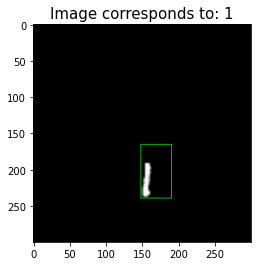

In [ ]:
plot_boxes(10)

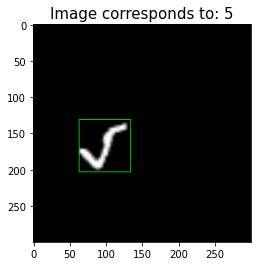

In [ ]:
plot_boxes(55)

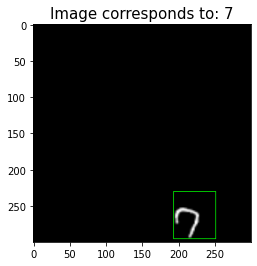

In [ ]:
plot_boxes(565)

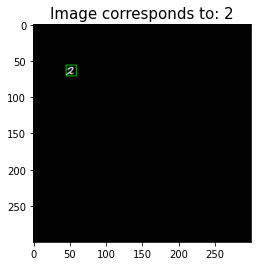

In [ ]:
plot_boxes(88)

## <b>Note: Images with Inaccurate Bounding Boxes

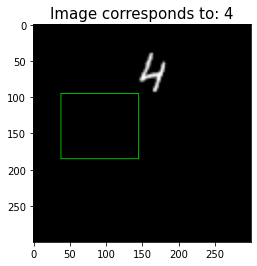

In [ ]:
plot_boxes(250)

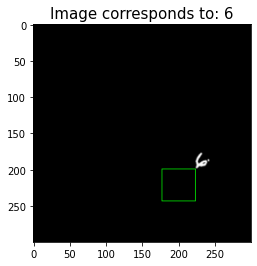

In [ ]:
plot_boxes(350)

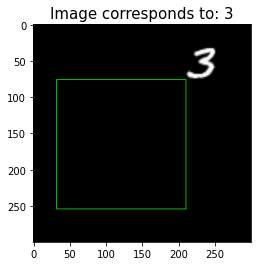

In [ ]:
plot_boxes(450)

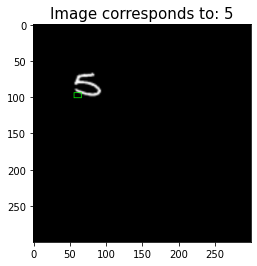

In [ ]:
plot_boxes(650)

## **Converting the list into a DataFrame**

In [ ]:
# Converting the list into DataFrame to define the label column so that this can be used along with its axis during predictions and the dataframe operations can be easily implemented
y_train = pd.DataFrame(y_train, columns=["Label"],dtype=object) 
y_test = pd.DataFrame(y_test, columns=["Label"],dtype=object)

In [ ]:
# Storing the value counts of target variable
count=y_train.Label.value_counts()
print(count)
print('*'*10)
count=y_train.Label.value_counts(normalize=True)
print(count)

1    1062
3    1044
9    1039
8    1018
7    1018
6    1001
4     985
0     968
2     941
5     924
Name: Label, dtype: int64
**********
1    0.1062
3    0.1044
9    0.1039
8    0.1018
7    0.1018
6    0.1001
4    0.0985
0    0.0968
2    0.0941
5    0.0924
Name: Label, dtype: float64


## <b> Converting the target features into arrays

In [ ]:
y_train=y_train.astype('float')
y_test=y_test.astype('float')

# Converting the pixel values into Numpy array as arrays are computationally faster as compared to lists
y_train_boxes_scaled= np.array(y_train_boxes_scaled,dtype='float32') 
y_test_boxes_scaled= np.array(y_test_boxes_scaled,dtype='float32') 


Over here, we delete the unrequired variables to save memory, as this would also help in training the model without resulting in an error due to memory exhaust.

In [ ]:
# Deleting the y_train_boxes and y_test_boxes variables to use the memory/RAM efficiently.
del y_train_boxes
del y_test_boxes

## <b> Initializing Random Seeds

In this step, we fix the seed for random number generators so that we can ensure we receive the same output every time.

In [ ]:
from tensorflow.keras import backend
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

## <b> Building the Model</b>
Here there will be 2 sections in the model-building process:
- The first section is for classification
- The second one is for regression / object detection

Objection detection = a classification + regression problem.<br>

So we need a classification layer which would classify the images into 10 categories, and we also need a regression layer which would plot the bounding boxes around the numbers in the images.<br>




In [ ]:
def get_model():

    # Using the VGG16 model to implement transfer learning
    # We are defining include_top=false to remove the dense layers from the VGG16 model
    vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(300, 300, 3)))
    # Freezing all VGG layers so they will *not* be updated during the training process
    vgg.trainable = False
    # flatten the max-pooling output of VGG16 so that we can add the required dense layers to the model.
    flatten = vgg.output
    x = Flatten()(flatten)

    # Adding a classification layer to classify the labels
    classifier_head = Dropout(0.3)(x)
    # Adding a output layer for labels with 10 neurons
    classifier_head = Dense(10, activation='softmax', name='label')(classifier_head)

    # Adding a Regression layer to predict the bounding boxes
    reg_head = Dense(128, activation='relu')(x)
    reg_head = Dense(64, activation='relu')(reg_head)
    reg_head = Dense(32, activation='relu')(reg_head)
    reg_head = Dense(16, activation='relu')(reg_head)
    # Adding the output layer to output 4 regression outputs for bounding boxes
    reg_head = Dense(4, activation='sigmoid', name='bbox')(reg_head)
    
    return Model(inputs=vgg.input, outputs=[classifier_head, reg_head])

In [ ]:
# Calling the get_model() function
model=get_model()

In [ ]:
# Plotting the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 300, 300, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 300, 300, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

## <b> Initializing the Optimizer and Loss Metrics</b>
- **SGD with Momentum over Adam**, as it generalizes and gives better performance than Adam, although Adam is computationally faster.
- As our problem involves both classification and regression, we will use <b>sparse_categorical_entropy</b> as the loss metric for the classification of the labels and we will use <b>mean squared error(mse)</b> as a loss metric for the regression on the bounding box values.

In [ ]:
# Using SGD optimizer with momentum as it generalizes better than other optimizers like Adam
opt = SGD(learning_rate=0.01,momentum=0.94)
model.compile(optimizer=opt, loss=['sparse_categorical_crossentropy','mse'])

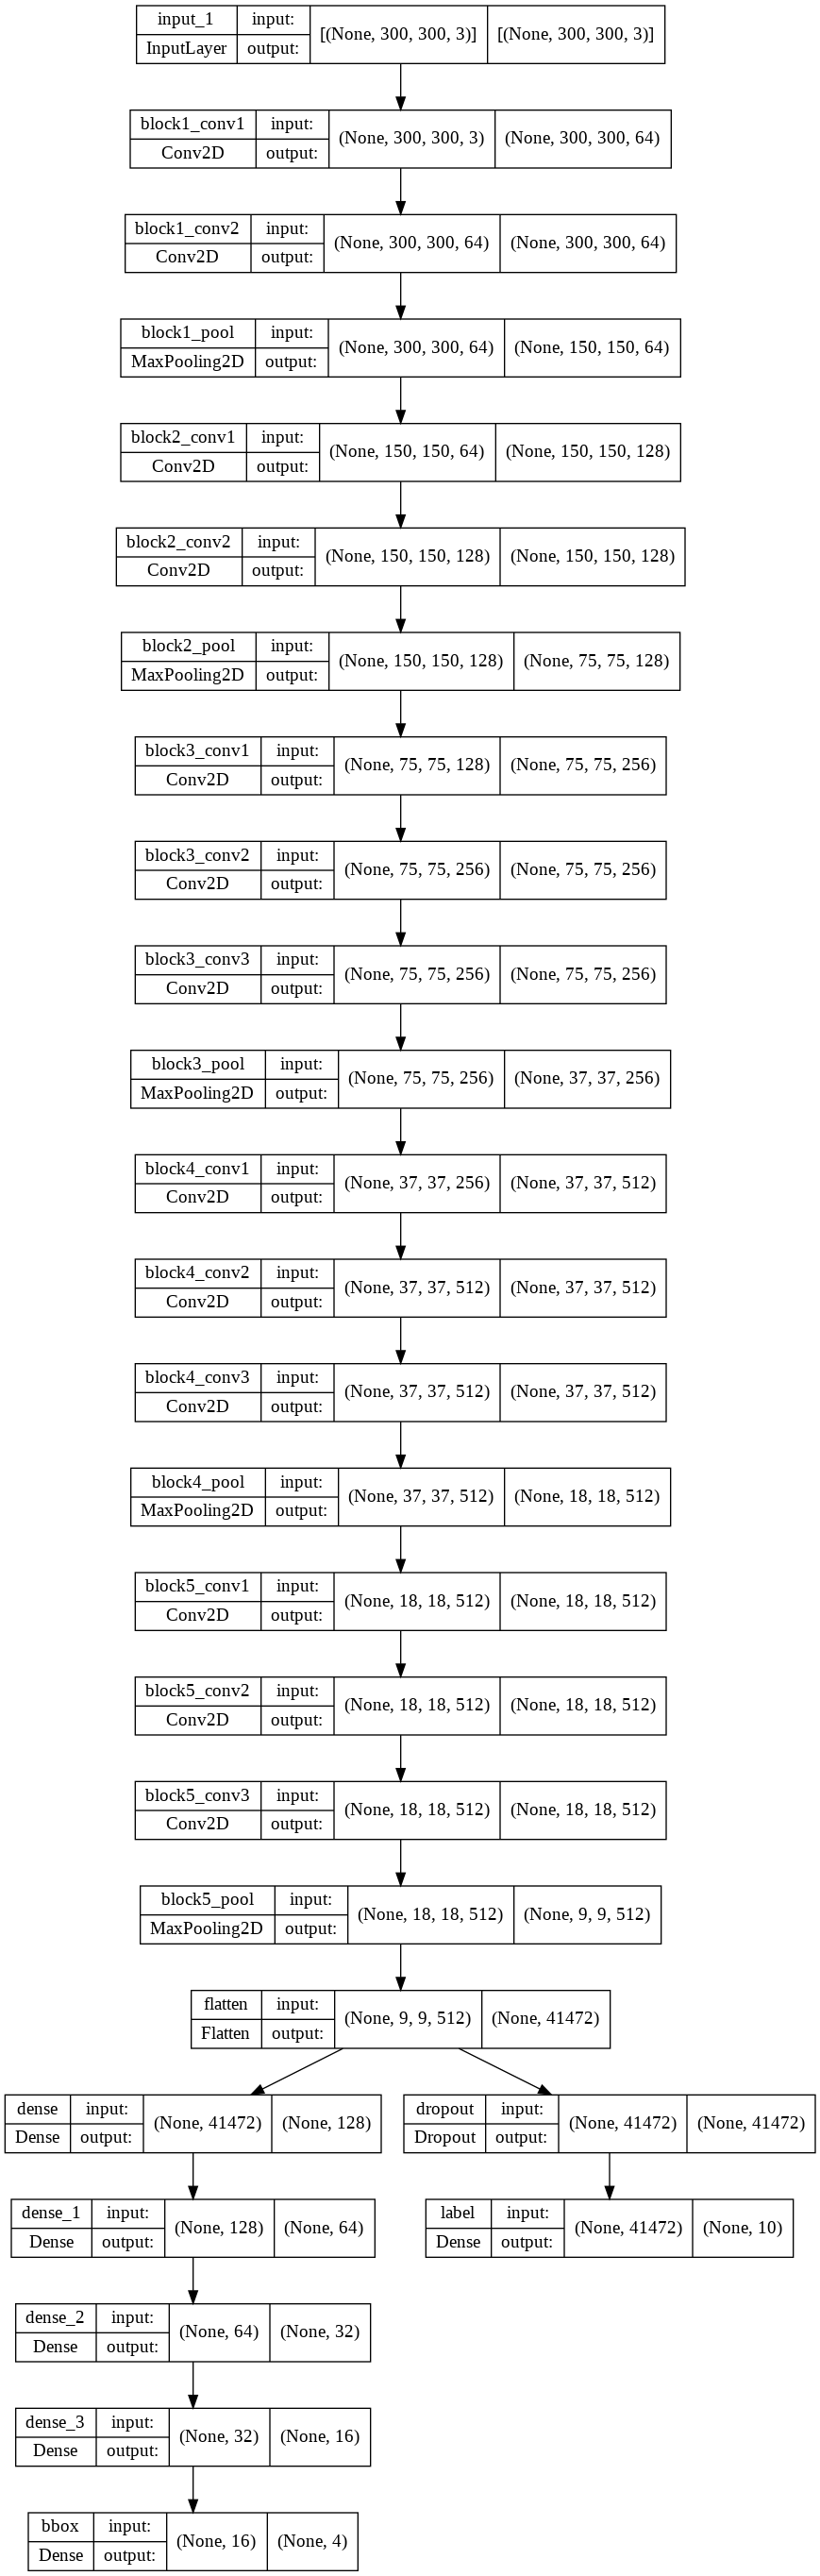

In [ ]:
 # plotting the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

- We can observe from the model plot that the model accepts and input of shape (300,300,3) i.e. images with a height and width of (300,300,3).
- We also observe that **we are using the VGG16 model architecture** before the flatten layer.
- We observe that after the flatten layer, **we have two sub-branches**: one being used for classification, and the other for regression.
- The branch on the left-hand side is used for regression to predict the bounding boxes for the images, and the one on the right is used to predict the classification label for each image.

In [ ]:
# Fitting the model with 10 epochs and validation_split as 10%
history=model.fit(X_train, 
          [y_train,y_train_boxes_scaled],  
          epochs=10, 
          batch_size=64,validation_split=0.1)  

Epoch 1/10
141/141 [==============================] - 111s 640ms/step - loss: 322.4534 - label_loss: 322.4415 - bbox_loss: 0.0119 - val_loss: 229.4984 - val_label_loss: 229.4953 - val_bbox_loss: 0.0031
Epoch 2/10
141/141 [==============================] - 84s 595ms/step - loss: 211.3688 - label_loss: 211.3665 - bbox_loss: 0.0022 - val_loss: 187.6271 - val_label_loss: 187.6250 - val_bbox_loss: 0.0021
Epoch 3/10
141/141 [==============================] - 84s 599ms/step - loss: 170.4011 - label_loss: 170.3997 - bbox_loss: 0.0015 - val_loss: 162.4688 - val_label_loss: 162.4673 - val_bbox_loss: 0.0015
Epoch 4/10
141/141 [==============================] - 84s 596ms/step - loss: 142.7105 - label_loss: 142.7094 - bbox_loss: 0.0011 - val_loss: 141.3221 - val_label_loss: 141.3208 - val_bbox_loss: 0.0013
Epoch 5/10
141/141 [==============================] - 84s 596ms/step - loss: 133.5760 - label_loss: 133.5751 - bbox_loss: 9.2917e-04 - val_loss: 193.2924 - val_label_loss: 193.2912 - val_bbox_los

### <b>Observations

- Here, **we have used 10% of our Training data as Validation data.** This is separate from the inital 20% of the whole dataset that was kept aside as the Testing dataset. 
- So our **Train-Validation-Test percentage split** is basically **72-8-20**.
- Here there are 4 values that we need to consider: bbox_loss and label_loss for the training data, and val_bbox_loss and val_label_loss for validation data.
- We have defined mse loss for the regression problem of predicting bounding boxes and sparse_categorical_entropy for the prediction of labels, as it is a multi-class classification problem.
- We observe that **the mse value and the cross_entropy value are decreasing per epoch**, starting from the first epoch to the tenth epoch.
- This CNN, as we would expect, is more computationally intense to train than the regular CNNs used for image classification, and that needs to be kept in mind when training such models. On a regular CPU, it takes considerable time even to train just the 10 epochs displayed above.



In [ ]:
# Deleting the X_train variable to use the memory/RAM efficiently
# Here we will be deleting the non-required variable to use the memory efficiently and to ignore the memory exhausted error.
del X_train

## **Model Evaluation**

In [ ]:
# Obtaining the predictions for labels and bounding boxes on test data
# Here yhat1 hold the prediction of labels in OHE format and yhat2 holds the predictions of bounding boxes
yhat1, yhat2 = model.predict(X_test)

# Obtaining the class from the onehot encoded output
yhat1_classes=np.argmax(yhat1,axis=1)

# calculate Mean_Absolute_Error for regression model/ bounding boxes
mae = mean_absolute_error(y_test_boxes_scaled, yhat2)
print('MAE: %.3f' % mae)

# calculate Mean_Squared_Error for regression model/ bounding boxes
mse = mean_squared_error(y_test_boxes_scaled, yhat2)
print('MSE: %.3f' % mse)

# evaluate accuracy for classification model/ labels
acc = accuracy_score(y_test['Label'], yhat1_classes)
print('Accuracy: %.3f' % acc)

MAE: 0.023
MSE: 0.001
Accuracy: 0.667


### **Observations**
- We observe that the bounding boxes are predicted with lesser errors - an MAE value of 0.023 and MSE value of 0.001.
- However, the labels only have an accuracy of about **67%** during prediction on test data. 
- **This low accuracy is primarily due to low-quality annotations and ground-truth bounding boxes in this object detection dataset.** Even though the MSE is very low (meaning the regression task has ostensibly performed well), that is in relation to the poor ground-truth bounding boxes which don't properly encapsulate the handwritten digit image, and due to that, the classification portion of the CNN is not able to perform well in the region localized by the poor bounding boxes, as from its perspective, the handwritten digits within the bounding boxes are not clearly discernible.

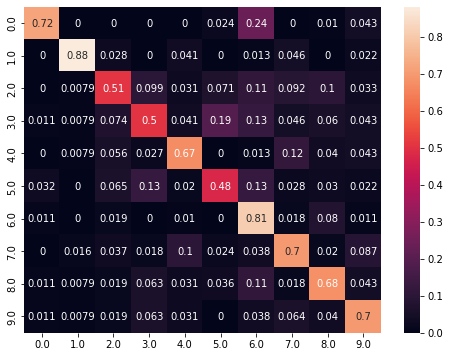

In [ ]:
# Plotting the confusion matrix
cf_matrix = confusion_matrix(y_test['Label'], yhat1_classes)

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n1, xticklabels=np.unique(y_test['Label']), yticklabels=np.unique(y_test['Label']), annot=True)

### Observations
- We can observe that most of the classes are classified correctly with a 70% accuracy but there are some classes like 2,3 and 5 are classified incorrectly.
- We can also observe that 6 is sometimes misclassified as 0 and 5 is misclassified as 3.


## **Plotting the Output Predictions**

In [ ]:
def plot_predictions(index):
  '''Make bounding box predictions on the input image'''

  label,preds = model.predict(X_test[index].reshape(1,300,300,3))               # reshaping and providing a single input image
  (startX, endX,startY, endY) = preds[0]                                        # Getting the bounding box
  label=np.argmax(label)                                                        # Getting the label
  image = X_test[index].reshape(300,300,3)                                      # Reshaping the image to 300,300,3
  (h, w) = X_test[index].shape[:2]                                              # Obtaining the height and width of the image

  # scale the predicted bounding box coordinates based on the image dimensions so that the box fits correctly on the image
  startX = int(startX*w )
  startY = int(startY*h )
  endX = int(endX *w)
  endY = int(endY*h)
  print((startX, endX,startY, endY))

  # Draw the predicted bounding box on the image
  cv2.rectangle(image, (startX,startY),(endX,endY), color=(255,0,0), thickness=2)
  plt.title("Image corresponds to: " + str(label),{'fontsize':15})              # Print the labels as the title of the image
  plt.imshow(image)

(46, 222, 121, 271)


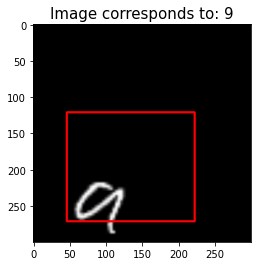

In [ ]:
plot_predictions(55)

(63, 132, 108, 170)


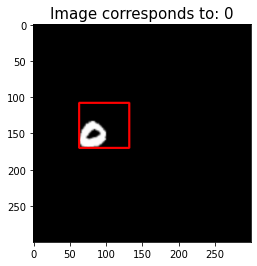

In [ ]:
plot_predictions(66)

(28, 48, 49, 104)


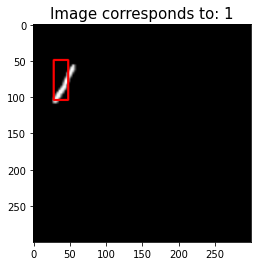

In [ ]:
plot_predictions(99)

(105, 167, 139, 209)


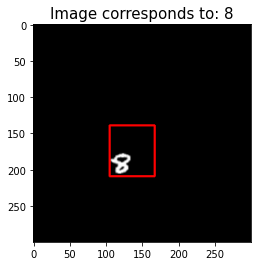

In [ ]:
plot_predictions(255)

We observe that the bounding boxes are not always predicted to the localization level we would expect from a high-quality object detection system. This may be the reason for the relatively low classification accuracy of the CNN in this object detection problem.